In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [4]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

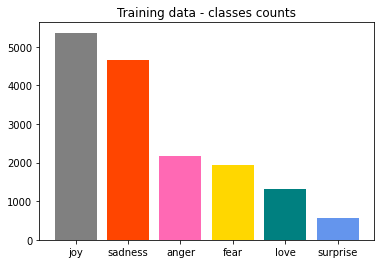

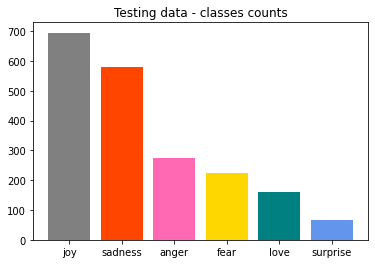

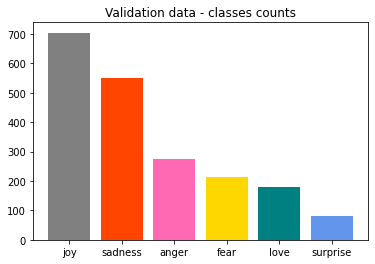

In [5]:
# Visualize classes counts
%matplotlib inline
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.value_counts().index,y_train.value_counts().values, color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.value_counts().index,y_test.value_counts().values, color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.value_counts().index,y_val.value_counts().values, color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [6]:
y_train

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15995    sadness
15996    sadness
15997        joy
15998      anger
15999    sadness
Name: Emotion, Length: 16000, dtype: object

In [7]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

In [8]:
y_train

array([4, 4, 0, ..., 2, 0, 4])

In [9]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [10]:
# Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [11]:
# Build neural network architecture
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
adam = Adam(learning_rate=0.05)
#code here
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabSize, embedding_dim, input_length=256, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation= 'softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               44928     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,291,022
Trainable params: 54,022
Non-trainable params: 3,237,000
_________________________________________________________________


In [12]:
#Callback
callback = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights = True,
)

In [13]:
# Fit model
history = model.fit(
    X_train, 
    y_train, 
    batch_size= 32,
    epochs=100, 
    validation_data=(X_val, y_val), 
    verbose=2,
    callbacks=callback)

print("Selesai")


Epoch 1/100
500/500 - 19s - loss: 1.0999 - accuracy: 0.5877 - val_loss: 0.5688 - val_accuracy: 0.7965 - 19s/epoch - 37ms/step
Epoch 2/100
500/500 - 12s - loss: 0.3815 - accuracy: 0.8616 - val_loss: 0.2880 - val_accuracy: 0.8940 - 12s/epoch - 24ms/step
Epoch 3/100
500/500 - 9s - loss: 0.2336 - accuracy: 0.9057 - val_loss: 0.2195 - val_accuracy: 0.9145 - 9s/epoch - 17ms/step
Epoch 4/100
500/500 - 9s - loss: 0.1736 - accuracy: 0.9271 - val_loss: 0.2092 - val_accuracy: 0.9160 - 9s/epoch - 17ms/step
Epoch 5/100
500/500 - 12s - loss: 0.1431 - accuracy: 0.9355 - val_loss: 0.1882 - val_accuracy: 0.9200 - 12s/epoch - 25ms/step
Epoch 6/100
500/500 - 13s - loss: 0.1225 - accuracy: 0.9446 - val_loss: 0.1766 - val_accuracy: 0.9205 - 13s/epoch - 26ms/step
Epoch 7/100
500/500 - 12s - loss: 0.1060 - accuracy: 0.9507 - val_loss: 0.1942 - val_accuracy: 0.9225 - 12s/epoch - 25ms/step
Epoch 8/100
500/500 - 11s - loss: 0.0943 - accuracy: 0.9566 - val_loss: 0.1768 - val_accuracy: 0.9320 - 11s/epoch - 23ms/s

In [14]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 1s 12ms/step - loss: 0.3838 - accuracy: 0.9195


[0.38381752371788025, 0.9194999933242798]

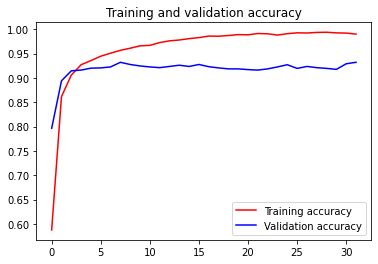

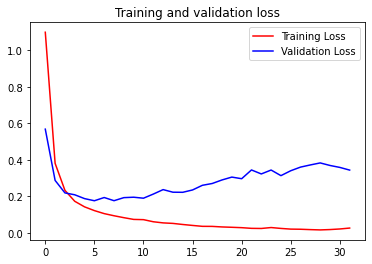

In [15]:

# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Classify custom sample

sentences = [
            'she was herself in such high spirits at that moment, so far from sorrow, sadness, or self-reproach, that she purposely deceived herself as young people often do.'
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

she was herself in such high spirits at that moment, so far from sorrow, sadness, or self-reproach, that she purposely deceived herself as young people often do.
joy : 0.9999862909317017



In [18]:
df_sample = pd.read_csv('tweets_clean.csv') #load data tweet yang sudah di cleaning
df_sample.head(3) #lihat data 3 paing atas

,Unnamed: 0,keyword,text
0,0,ablaze,communal violence in bhainsa telangana stones ...
1,1,ablaze,telangana section has been imposed in bhainsa...
2,2,ablaze,arsonist sets cars ablaze at dealership


In [19]:
df_tes = df_sample.text #ambil kolom textnya aja untuk di analisis sentimennya
df_tes

0        communal violence in bhainsa telangana stones ...
1        telangana section  has been imposed in bhainsa...
2                 arsonist sets cars ablaze at dealership 
3                arsonist sets cars ablaze at dealership  
4        lord jesus your love brings freedom and pardon...
                               ...                        
10939    media should have warned us well in advance th...
10940    i feel directly attacked  i consider moonbin a...
10941    i feel directly attacked  i consider moonbin a...
10942    ok who remember outcast nd the dora au those a...
10943          jake corway wrecked while running th at irp
Name: text, Length: 10944, dtype: object

In [22]:
hasil = [] #hasil simpan disini
sentences = df_tes #text yang mau di analisis sentimentnya
i = 1
for sentence in sentences:
    sentence = clean(str(sentence)) #di cleansing lagi incase ada yg miss
    sentence = tokenizer.texts_to_sequences([sentence]) #tokenizer
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre') #dibikin sequences
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0] #label encoder
    proba =  np.max(model.predict(sentence)) #prediksi
    a = result
    hasil.append(a)

In [23]:
#bikin df hasil analisis sentimen
column = {'Sentiment' : hasil}
df_hasil = pd.DataFrame(column) 
df_hasil

,Sentiment
0,anger
1,anger
2,fear
3,fear
4,joy
...,...
10939,anger
10940,sadness
10941,sadness
10942,joy


In [25]:
df_end = pd.concat([df_sample, df_hasil]) #merger terus simpan hasilnya --lanjut ke notebook visualisasi
df_end.to_csv('tweets_final.csv')